<hr style="height:10px"> 
 
<div class='container2'>
		<div>
			<img src='california.png' ALIGN='left' style='width:10em'>
		</div>	
	<div style='padding: 0 7em 2em 12em;'>
	<h1>Laboratório de Inovação e Automação 1 (LIA 1)</h1>
	<div style="font-size:12pt;float:left;"> 2025/1 | 24M34 | Sala 200 CAE</div><br><br>
    <div style="font-size:12pt;float:left;"><b>Projetos de Inteligência Artificial - Projeto Capitulo 2 </b></div>
	</div>
</div>


 <hr style="height:5px"> 

    
<h2>Aula 10 - Projeto ponta a ponta: Californian districts - <a href="https://github.com/ageron/data/raw/main/housing.tgz">Housing</a> </h2>

Notebook desenvolvido por: Victor Noda


In [35]:
import os
import tarfile
import hashlib
import numpy as np
import pandas as pd
import urllib.request
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from zlib import crc32
from scipy import stats
from scipy.stats import randint
from sklearn.svm import SVR, LinearSVR
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit, train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer

**Carregamento de Dados**

O código irá baixar e carregar o conjunto de dados de habitação da Califórnia a partir de um arquivo `.tgz` hospedado no GitHub. Ele salva o arquivo localmente, extrai seu conteúdo com segurança e lê o CSV usando pandas. Por fim, exibe as primeiras linhas da tabela para visualização inicial.

In [38]:
# Função para carregar os dados
def load_housing_data():
    """Função para baixar e carregar os dados de habitação da Califórnia."""
    tarball_path = Path("datasets/housing.tgz")
    
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        print(f"Baixando dados de {url} para {tarball_path}")
        urllib.request.urlretrieve(url, tarball_path)
        print("Download completo.")
    
    print(f"Extraindo dados de {tarball_path}")
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets", filter="data")
    print("Extração completa.")
    
    csv_path = Path("datasets/housing/housing.csv")
    print(f"Carregando dados de {csv_path}")
    return pd.read_csv(csv_path)

# Carregar dados
housing = load_housing_data()
print("Dados carregados com sucesso.")
housing.head()

Extraindo dados de datasets/housing.tgz
Extração completa.
Carregando dados de datasets/housing/housing.csv
Dados carregados com sucesso.


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [40]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [42]:
print(housing["ocean_proximity"].value_counts())

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


Este código configura o estilo dos gráficos com `matplotlib`, ajustando tamanhos de fonte para elementos visuais. Em seguida, gera histogramas para cada atributo numérico do conjunto de dados de habitação, com 50 bins e dimensão 12x8. O gráfico permite visualizar a distribuição das variáveis.

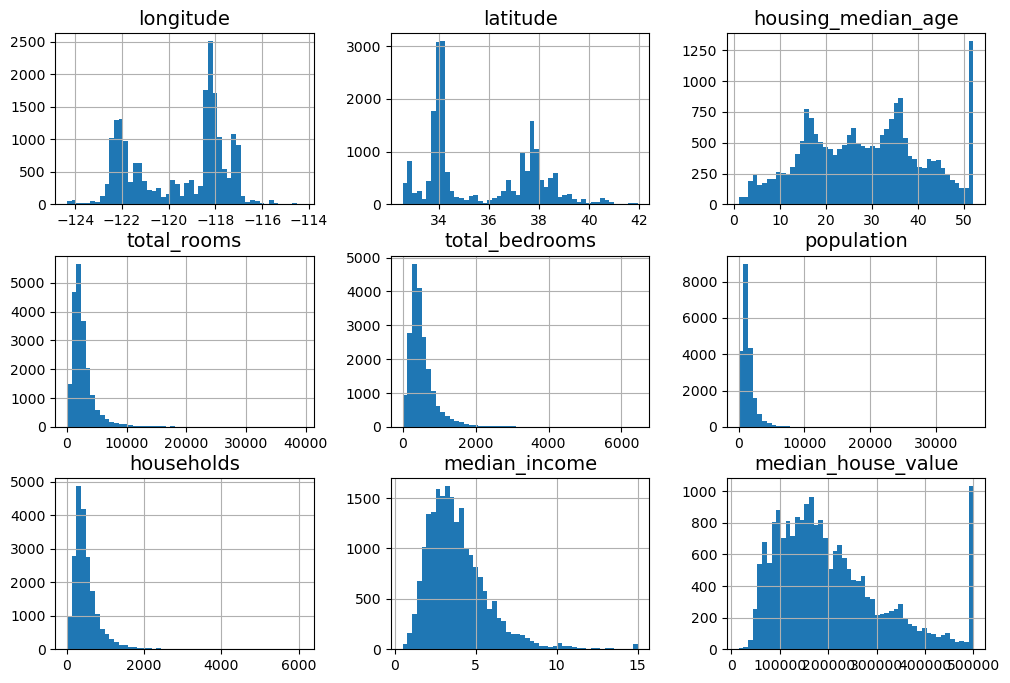

In [45]:
import matplotlib.pyplot as plt


plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
plt.show()

<Axes: >

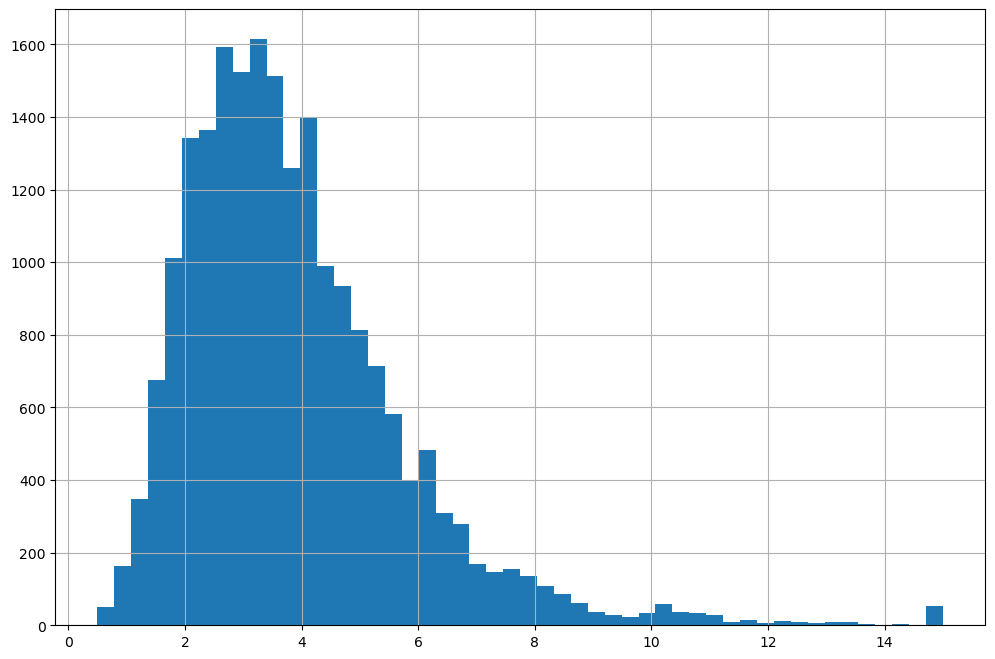

In [46]:
housing["median_income"].hist(bins=50, figsize=(12, 8))

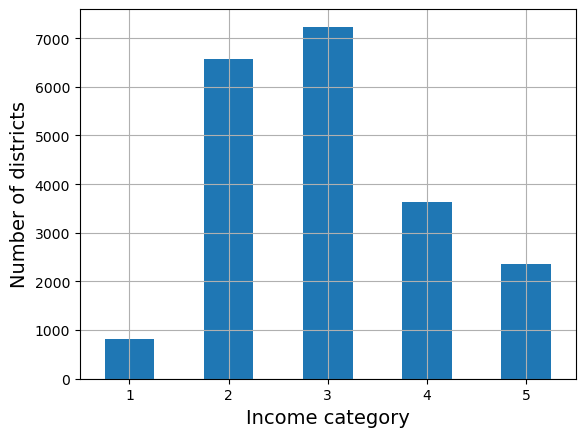

In [47]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

O código realiza uma divisão estratificada manual, garantindo que a proporção da variável `income_cat` seja mantida nos conjuntos de treino e teste. Ele embaralha os dados por categoria, separa 20% para teste e 80% para treino, e concatena os resultados finais em dois DataFrames.

In [52]:
np.random.seed(42)

# Proporção do conjunto de teste
test_ratio = 0.2

# Estratificação manual baseada em 'income_cat'
strat_test_set = pd.DataFrame()
strat_train_set = pd.DataFrame()

# Loop por cada categoria de renda
for cat in housing['income_cat'].unique():
    cat_group = housing[housing['income_cat'] == cat]
    n_test = int(len(cat_group) * test_ratio)
    
    # Embaralha os índices
    shuffled = cat_group.sample(frac=1, random_state=42)
    
    # Separa test e train
    strat_test_set = pd.concat([strat_test_set, shuffled.iloc[:n_test]])
    strat_train_set = pd.concat([strat_train_set, shuffled.iloc[n_test:]])

# Resetar índices
strat_test_set = strat_test_set.reset_index(drop=True)
strat_train_set = strat_train_set.reset_index(drop=True)

# Verificação da proporção
strat_test_set["income_cat"].value_counts(normalize=True)

income_cat
3    0.350703
2    0.318953
4    0.176200
5    0.114397
1    0.039748
Name: proportion, dtype: float64

### Visualização Geográfica Simples

Este trecho gera um gráfico de dispersão com `longitude` no eixo x e `latitude` no eixo y, permitindo visualizar a distribuição geográfica dos bairros na Califórnia.

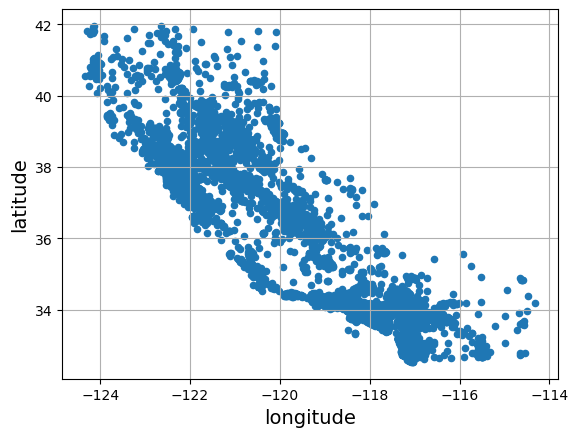

In [55]:
housing = strat_train_set.copy()

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

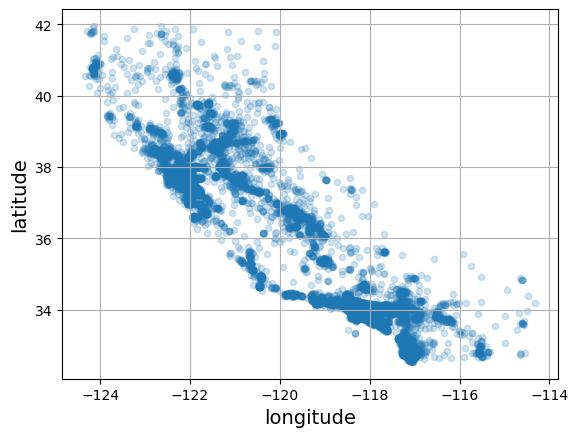

In [57]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

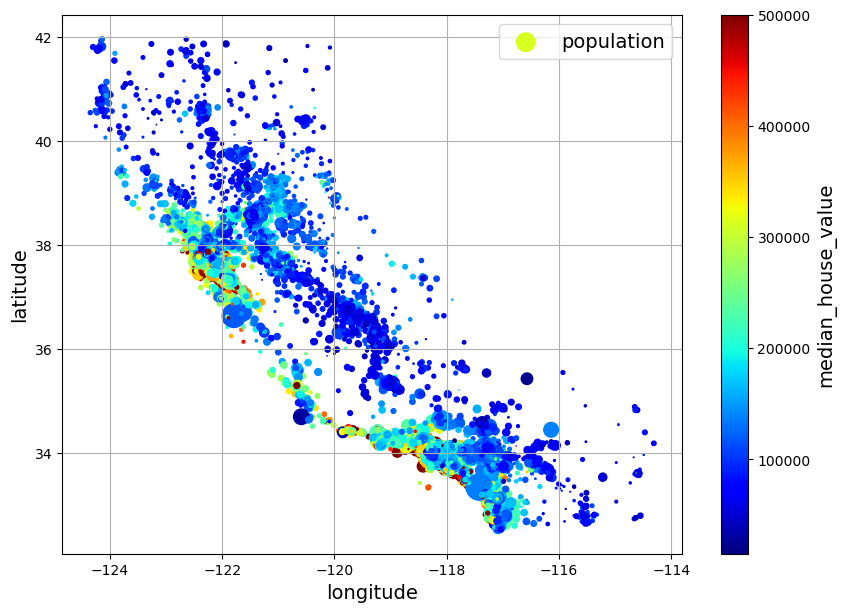

In [59]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

### Preparar os Dados para Algoritmos de Machine Learning

Vamos voltar ao conjunto de treino original e separar a variável alvo (note que `strat_train_set.drop()` cria uma cópia de `strat_train_set` sem a coluna; isso **não modifica** o próprio `strat_train_set`, a menos que você utilize `inplace=True`):

In [61]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Limpeza de Dados

No livro, são listadas 3 opções para lidar com valores `NaN`:

```python
housing.dropna(subset=["total_bedrooms"], inplace=True)  # opção 1
housing.drop("total_bedrooms", axis=1)                   # opção 2
median = housing["total_bedrooms"].median()              # opção 3
housing["total_bedrooms"].fillna(median, inplace=True)

Para cada opção, será criada uma cópia de housing para evitar modificar o original. A saída será filtrada nas linhas que originalmente continham valores ausentes.

In [65]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
36,-117.64,33.45,26.0,1528.0,NaN,607.0,218.0,6.2871,NEAR OCEAN,5
84,-122.01,37.94,23.0,3741.0,NaN,1339.0,499.0,6.7061,NEAR BAY,5
118,-122.08,37.37,29.0,1229.0,NaN,707.0,194.0,7.1108,NEAR BAY,5
316,-117.66,33.58,6.0,4186.0,NaN,1794.0,541.0,9.6986,<1H OCEAN,5
437,-118.27,34.17,52.0,2010.0,NaN,908.0,326.0,6.9135,<1H OCEAN,5


In [67]:
housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat


In [69]:
	
housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2

housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,income_cat
36,-117.64,33.45,26.0,1528.0,607.0,218.0,6.2871,NEAR OCEAN,5
84,-122.01,37.94,23.0,3741.0,1339.0,499.0,6.7061,NEAR BAY,5
118,-122.08,37.37,29.0,1229.0,707.0,194.0,7.1108,NEAR BAY,5
316,-117.66,33.58,6.0,4186.0,1794.0,541.0,9.6986,<1H OCEAN,5
437,-118.27,34.17,52.0,2010.0,908.0,326.0,6.9135,<1H OCEAN,5


In [71]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()

housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
36,-117.64,33.45,26.0,1528.0,NaN,607.0,218.0,6.2871,NEAR OCEAN,5
84,-122.01,37.94,23.0,3741.0,NaN,1339.0,499.0,6.7061,NEAR BAY,5
118,-122.08,37.37,29.0,1229.0,NaN,707.0,194.0,7.1108,NEAR BAY,5
316,-117.66,33.58,6.0,4186.0,NaN,1794.0,541.0,9.6986,<1H OCEAN,5
437,-118.27,34.17,52.0,2010.0,NaN,908.0,326.0,6.9135,<1H OCEAN,5


### Preenchimento de Dados Faltantes com Mediana

Este trecho do código utiliza o `SimpleImputer` para substituir valores ausentes nos atributos numéricos do dataset por suas respectivas medianas. Após o ajuste, os dados transformados são convertidos em um novo `DataFrame` com os mesmos nomes de colunas e índices originais. O resultado mostra que os valores ausentes foram corretamente preenchidos com a mediana calculada.

In [75]:
# Instancia o imputador com estratégia de mediana
imputer = SimpleImputer(strategy="median")

# Seleciona apenas atributos numéricos (exclui strings como 'ocean_proximity')
housing_num = housing.select_dtypes(include=[np.number])

# Ajusta o imputador aos dados
imputer.fit(housing_num)

# Exibe as estatísticas (medianas) aprendidas
print(imputer.statistics_)

# Verifica se os valores correspondem à mediana calculada manualmente
print(housing_num.median().values)

[-118.49     34.25     29.     2129.5     436.     1165.5     410.
    3.5341]
[-118.49     34.25     29.     2129.5     436.     1165.5     410.
    3.5341]


In [77]:
X = imputer.transform(housing_num)
imputer.feature_names_in_


array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [79]:

housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
36,-117.64,33.45,26.0,1528.0,436.0,607.0,218.0,6.2871
84,-122.01,37.94,23.0,3741.0,436.0,1339.0,499.0,6.7061
118,-122.08,37.37,29.0,1229.0,436.0,707.0,194.0,7.1108
316,-117.66,33.58,6.0,4186.0,436.0,1794.0,541.0,9.6986
437,-118.27,34.17,52.0,2010.0,436.0,908.0,326.0,6.9135


In [81]:
imputer.strategy

'median'

### Detecção de Outliers e Codificação de Variáveis Categóricas

Nesta etapa, o modelo `IsolationForest` é utilizado para identificar **outliers** com base nos atributos numéricos transformados. Em seguida, a variável categórica `ocean_proximity` é extraída e codificada com `OrdinalEncoder`, convertendo as categorias textuais em valores numéricos. A ordem das categorias é armazenada em `ordinal_encoder.categories_`.

In [84]:
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
outlier_pred

array([ 1, -1,  1, ..., -1,  1,  1])

In [85]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
0,<1H OCEAN
1,INLAND
2,INLAND
3,<1H OCEAN
4,<1H OCEAN
5,<1H OCEAN
6,NEAR BAY
7,NEAR BAY


In [88]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8]

array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [3.],
       [3.]])

In [90]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [92]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16514x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16514 stored elements in Compressed Sparse Row format>

In [94]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16514x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16514 stored elements in Compressed Sparse Row format>

In [96]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [98]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [100]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'income_cat'],
      dtype='object')

### Criação de Atributos Derivados

Este trecho define e aplica a função `add_extra_features`, que cria novos atributos com base em relações entre colunas do dataset: `rooms_per_household` e `population_per_household`. Opcionalmente, também pode gerar `bedrooms_per_room`. A função é incorporada ao pipeline com `FunctionTransformer`, e os novos atributos são integrados ao `DataFrame` original.

In [103]:
# obter os índices de coluna
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
0,-117.11,32.91,15.0,1840.0,235.0,855.0,241.0,7.5992,<1H OCEAN,5,7.634855,3.547718
1,-121.85,37.68,4.0,4719.0,741.0,1895.0,742.0,6.8132,INLAND,5,6.359838,2.553908
2,-118.12,34.18,44.0,2357.0,342.0,891.0,337.0,6.3467,INLAND,5,6.994065,2.643917
3,-121.85,37.44,8.0,426.0,61.0,241.0,55.0,7.309,<1H OCEAN,5,7.745455,4.381818
4,-117.75,33.84,16.0,3491.0,502.0,1496.0,509.0,6.6207,<1H OCEAN,5,6.858546,2.939096


Agora, vamos construir um pipeline para pré-processamento dos atributos numéricos

In [106]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[ 1.22385621, -1.27065025, -1.08401213, ...,  0.88072636,
         0.04404681, -1.31452587],
       [-1.1372385 ,  0.95980732, -1.95898831, ...,  0.37228325,
        -0.0470114 , -0.86837298],
       [ 0.72075375, -0.67679677,  1.22274326, ...,  0.62519633,
        -0.03876433, -1.0499112 ],
       ...,
       [ 1.218875  , -1.37352251,  1.38182983, ..., -0.93685717,
        -0.0272824 ,  2.6021426 ],
       [ 0.65599799, -0.78434504, -0.28857924, ..., -0.77902085,
         0.05258549,  0.72633964],
       [ 0.64105435, -0.87786527, -0.6067524 , ..., -0.65641447,
        -0.00925844,  1.22338811]])

In [108]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[ 1.22385621, -1.27065025, -1.08401213, ...,  0.        ,
         0.        ,  0.        ],
       [-1.1372385 ,  0.95980732, -1.95898831, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72075375, -0.67679677,  1.22274326, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.218875  , -1.37352251,  1.38182983, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.65599799, -0.78434504, -0.28857924, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.64105435, -0.87786527, -0.6067524 , ...,  0.        ,
         0.        ,  1.        ]])

In [121]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [123]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [334528. 285376. 285440. 330880. 300224.]


In [125]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68557.73640667829